In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros

In [4]:
pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 15

In [5]:
from simpletransformers.classification import ClassificationModel
import pandas as pd

In [6]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment.tsv',sep='\t',names=['category','text'])
y=df['category'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2) #train, test split
#validation split
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.1)

In [9]:
print(df)

            category                                               text
0      unknown_state  Ichayan fans pinne mmade ettan fansm ivde oru ...
1      not-malayalam             Tovi 🥰 Best Wishes From #Kunjikka Fans
2      unknown_state  Urutty koll .nallavanaaya unniyaya saiju kurup...
3      not-malayalam  Pls support me pls       My channel subscribe ...
4           Positive     Kalki super hit akum enn Bonny parayan paranju
...              ...                                                ...
19611  not-malayalam     Big love for Mammootty sir from Karnataka fans
19612  not-malayalam  Ye achaa hey mammootty. Mamangam dheka hey ach...
19613  unknown_state          Ithu endhaa igane views kuranju varunathu
19614  unknown_state    എന്റെ ചാനെൽ സബ്സ്ക്രൈബ് ചെയ്താൽ തിരിച്ചും ചെയും
19615       Negative         ഇതെന്ത് മൈര് views കുറഞ്ഞു ആണല്ലോ വരുന്നത്

[19616 rows x 2 columns]


In [10]:
list_of_class={'not-malayalam':0,'Positive':1,'Negative':2,'unknown_state':3,'Mixed_feelings':4}
y_val=[list_of_class[i.strip()]for i in y_val]
y_train=[list_of_class[i.strip()]for i in y_train]
y_test=[list_of_class[i.strip()]for i in y_test]

In [11]:
class_weights

array([3.45258526, 1.53242188, 0.49222083, 2.66417657, 0.60575179])

In [12]:
class_weights=[3.23783784, 1.797     , 0.48005343, 1.52503536, 0.71641196]
class_weights

[3.23783784, 1.797, 0.48005343, 1.52503536, 0.71641196]

In [13]:
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)

In [14]:
train_df

,0,1
0,Example sentence belonging to class 1,1
1,Example sentence belonging to class 0,0
2,Example eval senntence belonging to class 2,2


In [15]:
X_train

['Ittichane aadyame Byjus kaar alle kaanichath',
 'Nv ഫാൻസ്\u200c ലൈക്\u200c അടിക്കു മക്കളെ',
 'ആരോ ഒരാൾ അല്ല ഏട്ടൻ നമ്മുടെ ഏട്ടൻ ലാലേട്ടൻ',
 'Film othiri othiri ishttayi fahadikka soubinikka shine thudangi ellavarum mikacha abhinayam..onnum parayanilla.',
 'നമ്മുടെ ഇക്കാനെ സ്നേഹിക്കുന്നവർ ഒരു ലൈക് അടിച്ചിട്ട് പോവുക',
 'Class mass pwoli... Thrill bada bahii aaagayaaa...... Guyss.......... Wht a clss dark shade...',
 'Ente ikka ningale vellan oru lalapanum pattula',
 'Orika kanda veendum veendum kanan thonnum..',
 'Bro support koduthilenkilum dislike adikkathirunoode .',
 'തണ്ണീർമത്തൻ ദിനങ്ങൾ !!   നിങ്ങൾക്ക് കുട്ടിക്കാലത്തിലെയ്ക് ഒന്ന് തിരികെ പോണോ?  കുറച്ച് നൊസ്റ്റു അടിക്കണോ??  ഒരു 2:30 മണിക്കൂർ പൊട്ടി ചിരിക്കണോ??  ഇതൊക്കെ വേണമെങ്കിൽ ഇഷ്ടമാണെങ്കിൽ ധൈര്യമായി 100 മുടക്കിക്കോ    Guaranteed !!',
 'Angane adutha oru poli, Soubin, SB, Fahad',
 'padam vere leval kandu  ada oru figth',
 'Trailer kollillaa....shokham thanne Editing kurachukoodi mass aakaayirnnu, ithilum nallath shylock teaser th

In [16]:
df_train=pd.DataFrame(X_train,y_train)

In [17]:
df_valid=pd.DataFrame(X_val,y_val)
df_test=pd.DataFrame(X_test,y_test)

In [31]:
df_train['text'] = df['text'].replace(['പടം ഫ്ലോപ്പ് ആവും എന്നു തോന്നുന്നു.എന്തോ ഒരു എനർജി കുറവ്.ഏച്ചു കെട്ടിയപോലെ.'], 'padam flop aavum ennu thonunnu. entho oru energy kuravu eechu kettiyapole')

In [37]:
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_train.csv',sep=',',header=False)
df_valid.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_dev.csv',sep=',',header=False)
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_test.csv',sep=',',header=False)

In [38]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_train.csv',sep=',',names=['category','text'])
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_test.csv',sep=',',names=['category','text'])
df_valid=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/mal_full_sentiment_dev.csv',sep=',',names=['category','text'])

In [39]:
#df_valid=pd.read_csv('Malayalam_Code_Mix_val.csv',sep='\t',names=['f','m'])
df_valid=df_valid[['text','category']]
df_train=df_train[['text','category']]
df_test=df_test[['text','category']]
#df_valid

In [40]:
model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=5, args={'reprocess_input_data': True, 'overwrite_output_dir': True}) 
# You can set class weights by using the optional weight argument

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [32]:
df_train

,text,category
0,Ichayan fans pinne mmade ettan fansm ivde oru ...,3
1,Tovi 🥰 Best Wishes From #Kunjikka Fans,3
2,Urutty koll .nallavanaaya unniyaya saiju kurup...,1
3,Pls support me pls My channel subscribe ...,1
4,Kalki super hit akum enn Bonny parayan paranju,3
...,...,...
14117,"Enna poli padavanne , super oru rakshayumilla...",2
14118,Vere level monne movie Part 2 irakk,1
14119,Padam kandittum aathintea oru feel aagattu vit...,1
14120,Vineeth ettan polichu ennulavar like adi,3


In [43]:
model.train_model(df_train)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/14122 [00:00<?, ?it/s]

ValueError: ignored

In [32]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1570 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/197 [00:00<?, ?it/s]

In [33]:
df_test['text']

0                       Shane + soubin  + Fahad - ya baby
1       Dislike kunnamare olupundel poi kettithugi cha...
2                  Lal fans dis like adi ippozhe thudangi
3       നിനക്കിനി മലയാള ഇൻഡ്രസ്റ്റിയിൽ നിന്ന് പുളക്കാൻ...
4       100 crore Box office gross collection നേടിയതറി...
                              ...                        
3919    ഉയിരിൽ തൊടും തളിർ വിരലാവണേ നീ അരികേ നടക്കണേ അല...
3920      kidukki kalakki superettante ikkaikall the best
3921    കമന്റ്‌ കണ്ടു ചിരിച് വായിൽ തീട്ടം വന്നു പുല്ല്...
3922    ```HIGH VOLTAGE INSIDE.. UNAUTHORIZED PERSONS ...
3923            ലേഡി ഗെറ്റ് അപ്പ്‌ ഇക്ക എജ്ജാതി പെർഫെക്ഷൻ
Name: text, Length: 3924, dtype: object

In [35]:
predictions, raw_outputs = model.predict(df_test['text'].tolist())

  0%|          | 0/3924 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

In [36]:
predictions


array([0, 2, 2, ..., 3, 0, 1])

In [37]:
list_of_class_v={0:'not-malayalam',1:'Positive',2:'Negative',3:'unknown state',4:'Mixed feelings'}

In [38]:
print(classification_report([list_of_class_v[i] for i in y_test], 
                            [list_of_class_v[i] for i in predictions]))

                precision    recall  f1-score   support

Mixed feelings       0.30      0.08      0.13       253
      Negative       0.51      0.37      0.43       552
      Positive       0.68      0.80      0.74      1531
 not-malayalam       0.76      0.78      0.77       267
 unknown state       0.67      0.71      0.69      1321

      accuracy                           0.66      3924
     macro avg       0.59      0.55      0.55      3924
  weighted avg       0.64      0.66      0.64      3924



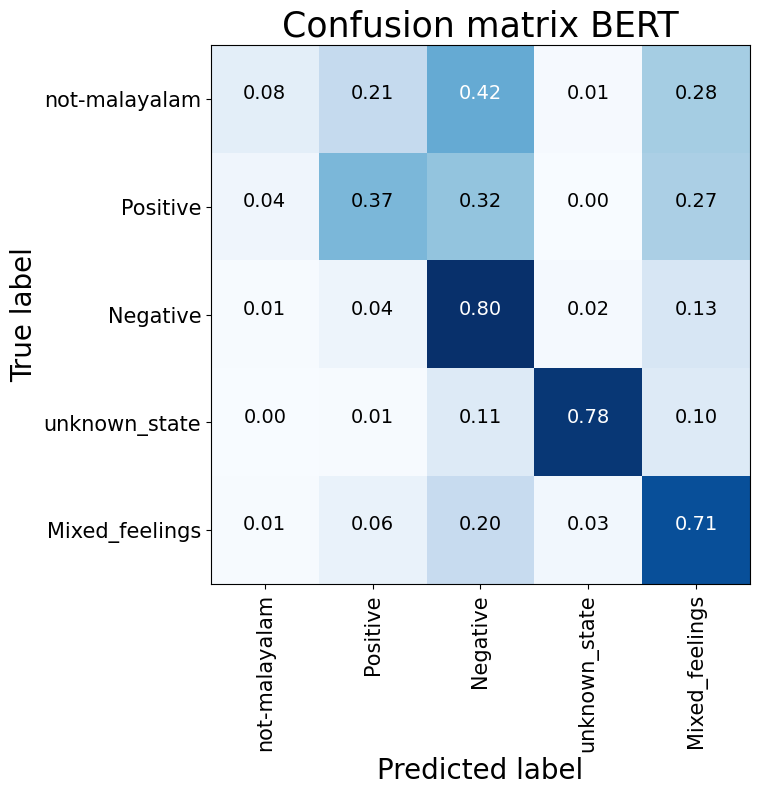

In [42]:
cnf_matrix = confusion_matrix([list_of_class_v[i] for i in y_test], 
                              [list_of_class_v[i] for i in predictions])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list_of_class.keys(), title="Confusion matrix BERT")
plt.show()

In [49]:
predictions, raw_outputs = model.predict('Laleta pattunna kadhapathram cheeyy ningalk charithra cinema sheriyaakoola Aa samayam 2 adipoli cinema cheyyan nok borayitund dialog')

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
list_of_class_v[predictions[0]]

'Negative'

In [62]:
import torch
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/NLP END SEM/malayalam_sentimental.h5')
